In [1]:
import threading
import numpy as np
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt

from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Axes: >

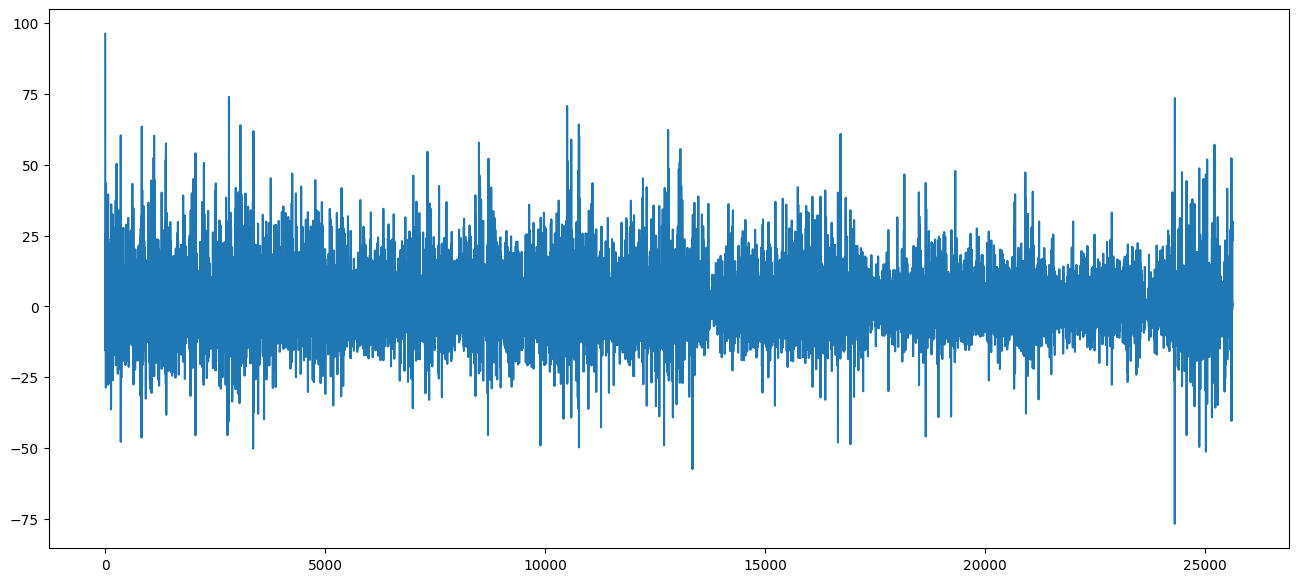

In [2]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])
series.diff().fillna(series).plot(figsize=(16, 7))

## Lets run some correlation tests

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

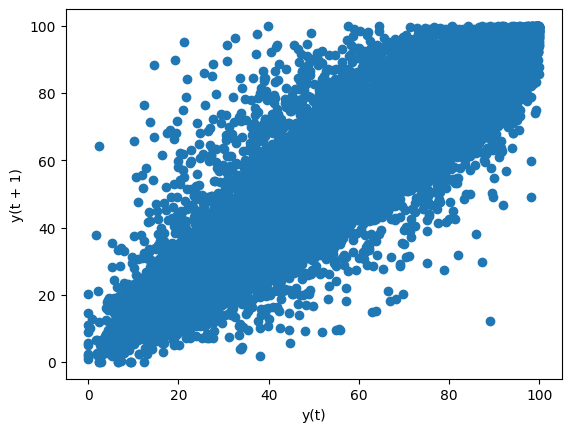

In [3]:
pd.plotting.lag_plot(series)

We can clearly see that there is some correlation in the data. Lets find the Pearson correlation coefficient.

In [4]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.922919
t+1  0.922919  1.000000


The value 0.922919 tell us, that there is stong positive correlation.

Autocorrelation plot:

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

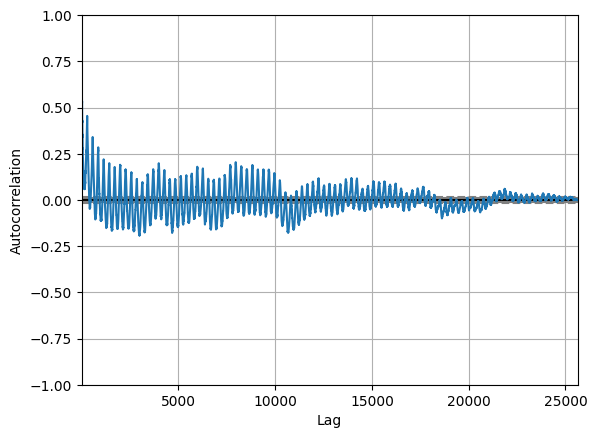

In [5]:
pd.plotting.autocorrelation_plot(series)

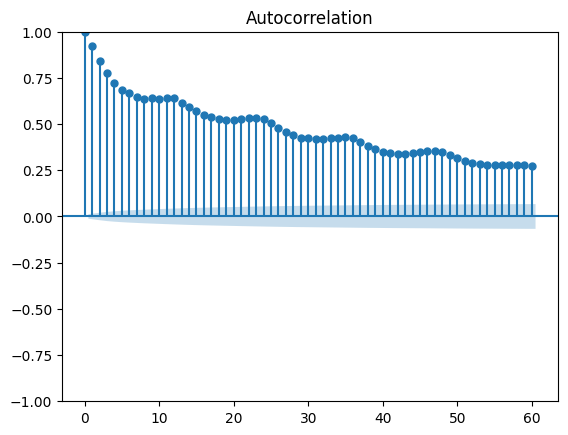

In [6]:
plot_acf(series, lags=60)
plt.show()

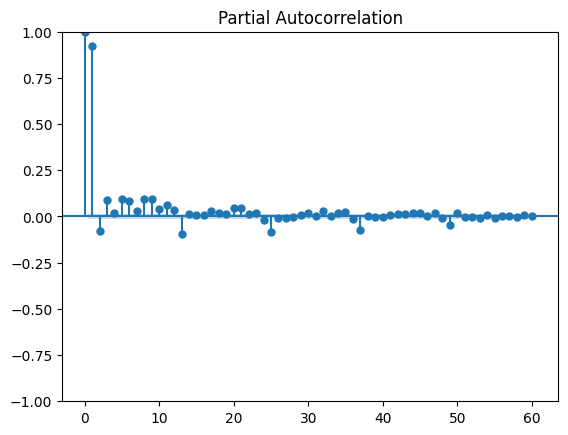

In [7]:
plot_pacf(series, lags=60)
plt.show()

## Ljung-Box Test and Information Criteria

In [8]:
X = series.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]

In [ ]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = AutoReg(X, lags=id)
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

result = []
with concurrent.futures.ThreadPoolExecutor(threading.active_count() - 1) as e:
    fut = [e.submit(worker_func, i) for i in range(1, len(X))]
    for r in concurrent.futures.as_completed(fut):
        result.append(r.result())

result = sorted(result, key= lambda x : x[0])
print(result)

1282
P Values:  [1.6411635723078144e-33, 2.7172465792639243e-31, 0.17761685245300834, 3.1463265943908904e-34, 4.2525963973348465e-38, 7.159057517765446e-08, 1.9682708807622842e-29, 1.854789630562735e-30, 2.7715088306848957e-06, 8.81000604743208e-11, 1.391233085863614e-09, 1.556354017252574e-25, 0.0057437305157173385, 0.032840282025243694, 0.10628391610221165, 0.014832492247557288, 0.4233590484640856, 0.4522941968975589, 0.021118720106460414, 0.016869878990421413, 0.4926192966356323, 0.518809674920766, 0.487326644493833, 9.59216481607321e-11, 0.8405268702114574, 0.8943303816126091, 0.9204307287765712, 0.8821683099605463, 0.5478772544805204, 0.9765920670639706, 0.8710852815078193, 0.9927323792791914, 0.9527971784938024, 0.8273441035733594, 0.9704188131058619, 2.2061504136755094e-06, 0.9999997218580868, 0.9999997762011412, 0.9999999212633854, 0.9999999544854643, 0.9999999832239308, 0.999998930506539, 0.9999999986926145, 0.9999998706091797, 0.999999999221163, 0.9999999949837631, 0.99999999

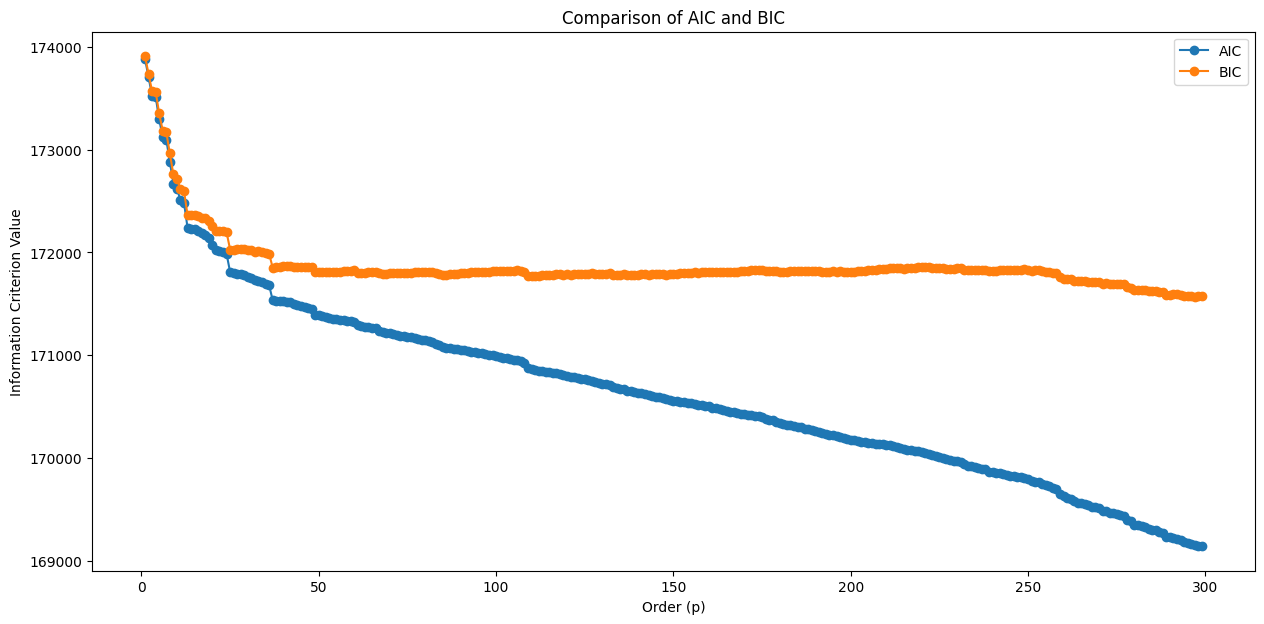

In [16]:
max_order = len(X)-size
p_values = []
aic_values = []
bic_values = []

print(max_order)

rnge = range(1, 300)

for p in rnge:
    model = AutoReg(train, lags=p)
    result = model.fit()
    residuals = result.resid
    aic_values.append(result.aic)
    bic_values.append(result.bic)

    result = acorr_ljungbox(residuals, lags=[p])
    p_value = result.iloc[0,1]
    p_values.append(p_value)
    
# Find the lag order with non-significant autocorrelation
threshold = 0.05
selected_order = np.argmax(np.array(p_values) < threshold) + 1
print("P Values: ", p_values)
print("Selected Order (p):", selected_order)

# Plot AIC and BIC values
plt.figure(figsize=(15,7))
plt.plot(rnge, aic_values, marker='o', label='AIC')
plt.plot(rnge, bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.legend()
plt.show()

Coefficients: [ 1.64147578  0.9499226  -0.16012616 ... -0.00256898 -0.00896752
  0.00489672]
predicted=80.537523, expected=85.289100
predicted=72.460094, expected=28.324500
predicted=54.851135, expected=20.574100
predicted=73.111134, expected=68.903500
predicted=64.785913, expected=9.146490
predicted=59.299827, expected=32.867900
predicted=65.974416, expected=12.900900
predicted=60.847636, expected=7.348350
predicted=58.516068, expected=14.900000
predicted=61.435215, expected=34.847800
predicted=58.182424, expected=6.001230
predicted=60.805721, expected=22.191500
predicted=62.836045, expected=62.296900
Test RMSE: 39.560


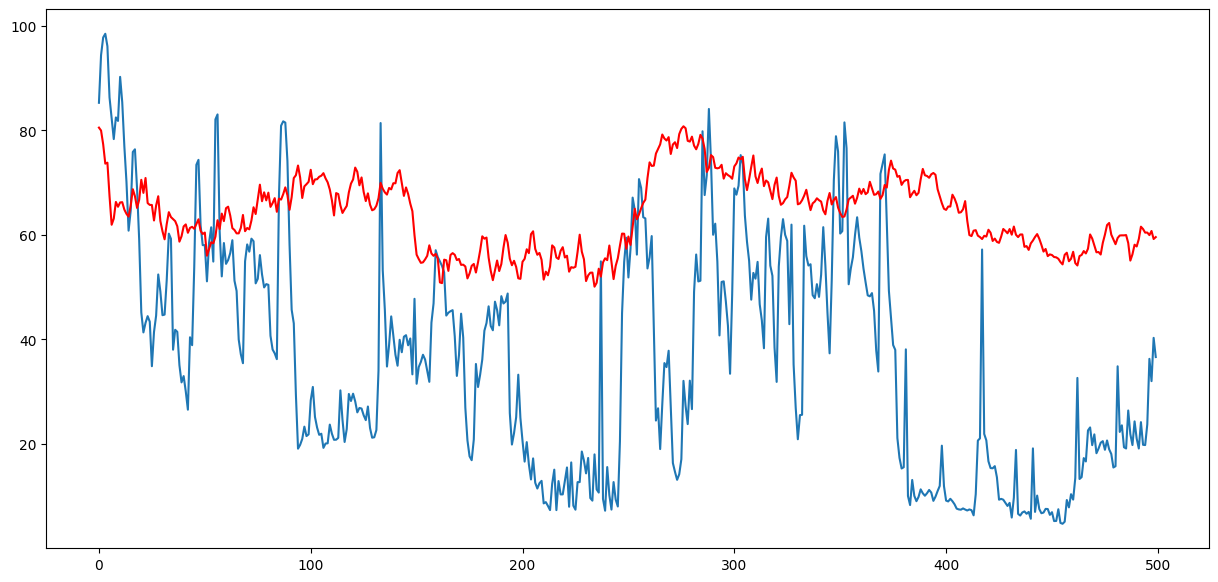

In [17]:
# train autoregression
model = AutoReg(train, lags=len(X)-size)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    if i % 100 == 0:
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.figure(figsize=(15,7))
plt.plot(test[:500])
plt.plot(predictions[:500], color='red')
plt.show()

In [18]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

mod = AutoReg(train, len(X)-size, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                24349
Model:                  AutoReg(1282)   Log Likelihood              -79998.911
Method:               Conditional MLE   S.D. of innovations              7.761
Date:                Tue, 21 Nov 2023   AIC                         162565.821
Time:                        18:07:57   BIC                         172897.089
Sample:                          1282   HQIC                        165922.686
                                24349                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6415      0.485      3.384      0.001       0.691       2.592
y.L1           0.9499      0.007    144.275      0.000       0.937       0.963
y.L2          -0.1601      0.009    -17.633      0.0

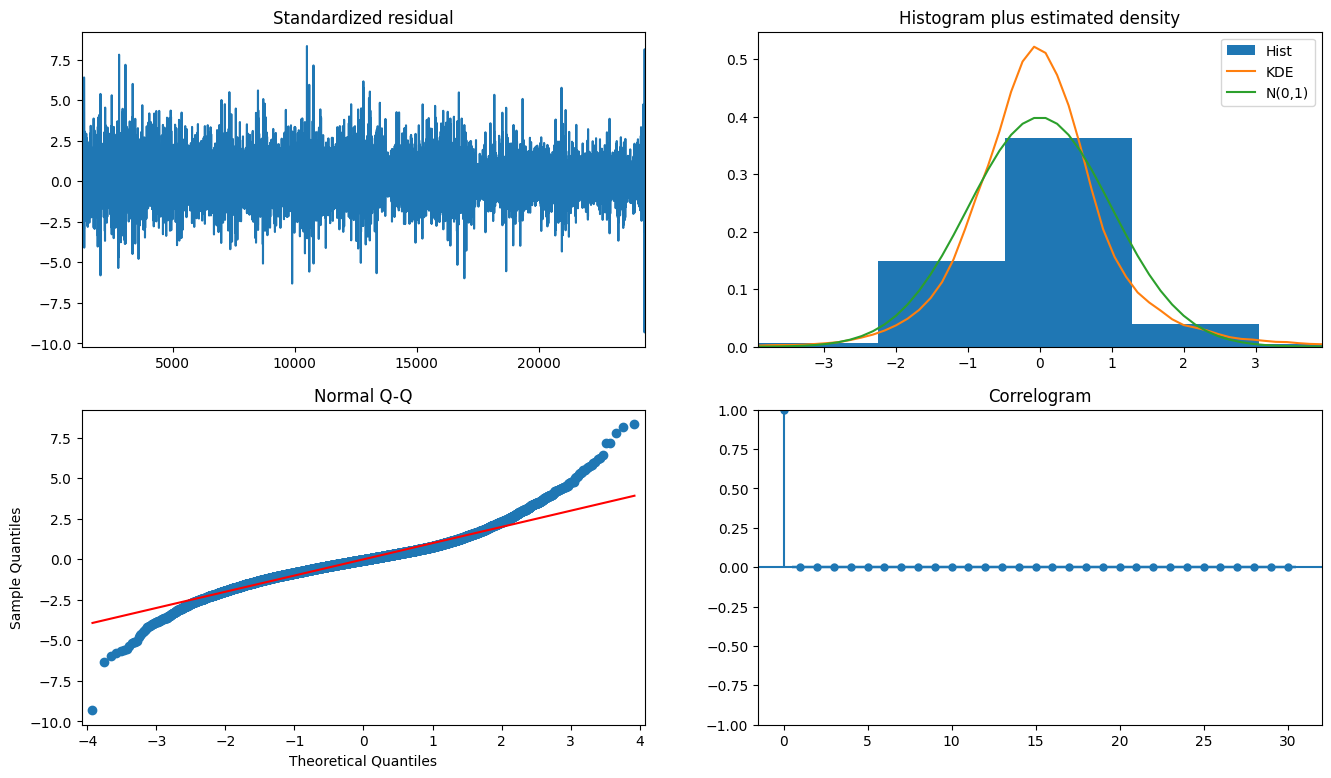

In [19]:

fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=30, fig=fig)

Test RMSE: 39.560


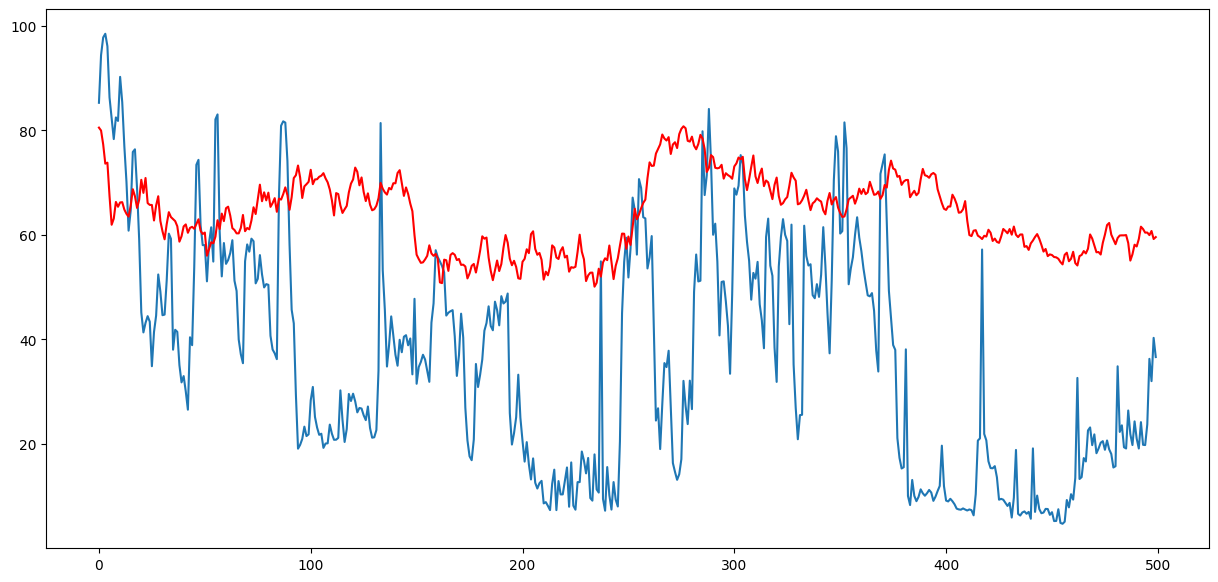

In [20]:
pred = res.predict(start=len(train), end=(len(series)-1), dynamic=False)
error = sqrt(mean_squared_error(test, pred))
print(f"Test RMSE: {error:.3f}")
plt.figure(figsize=(15,7))
plt.plot(test[:500])
plt.plot(pred[:500], color='red')
plt.show()    